In [32]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
from src.activationregion.core import exact_count_2D
from src.activationregion.utils.plot import plot_regions_exact
from src.activationregion.utils.utils import random_mnist_images
import random

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [33]:
# Load the MNIST dataset

image_size = 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size,image_size)),
    transforms.Lambda(lambda x: x.view(image_size * image_size, 1)),
])
root_folder = 'src/mammoth/data/MNIST'
train_dataset = datasets.MNIST(root=root_folder, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=root_folder, train=False, download=True, transform=transform)

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 60000
Test dataset: 10000


Batch images shape: torch.Size([128, 256, 1])
Batch labels shape: torch.Size([128])


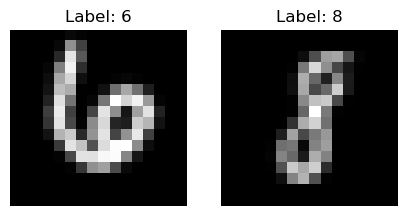

In [34]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

# plot some images
fig, axes = plt.subplots(1, 2, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].view(image_size, image_size).numpy(), cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

In [35]:
class MLP(nn.Module):
    def __init__(self, n_in, width=16, depth=4):
        super(MLP, self).__init__()
        self.n_in = n_in
        layers = []
        layers.append(nn.Linear(n_in, width, bias=True))
        layers.append(nn.ReLU())
        for i in range(1, depth):
            layers.append(nn.Linear(width, width, bias=True))
            layers.append(nn.ReLU())
        self.classifier = nn.Linear(width, 10, bias=True)
        self._features = nn.Sequential(*layers)
        self.init_weights()
        self.n_neurons = self.count_neurons()

    def count_neurons(self):
        total_neurons = 0
        for layer in self._features:
            if isinstance(layer, nn.Linear):
                total_neurons += layer.out_features
        return total_neurons

    def init_weights(self):
        for layer in self._features:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                nn.init.normal_(layer.bias, std=10**-6)
        nn.init.kaiming_normal_(self.classifier.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.classifier.bias, std=10**-6)

    def forward(self, x):
        x = x.view(-1, self.n_in)
        for layer in self._features:
            x = layer(x)
        output = self.classifier(x)
        return output
    
model = MLP(image_size**2, width=16, depth=4)

Images plane shape: torch.Size([3, 256, 1])


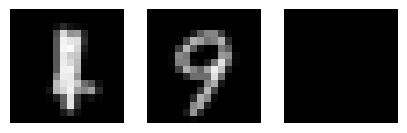

In [36]:
MNIST_PATH = r'src/mammoth/data/MNIST'
images_plane = random_mnist_images(2, MNIST_PATH, image_size=image_size)
zero = 10**(-3)*torch.ones((1, image_size**2, 1), dtype=torch.float32)
images_plane = torch.cat((images_plane, zero), dim=0)

print(f"Images plane shape: {images_plane.shape}")
fig, axes = plt.subplots(1, 3, figsize=(5, 5))
img = [1, 1, 1]
for i, ax in enumerate(axes.flat):
    img[i] = axes[i].imshow(images_plane[i].view(image_size, image_size).numpy(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

#cbar = fig.colorbar(img[0], ax=axes, location='right', fraction=0.05, pad=0.02)
plt.show()

Number of regions: 3881


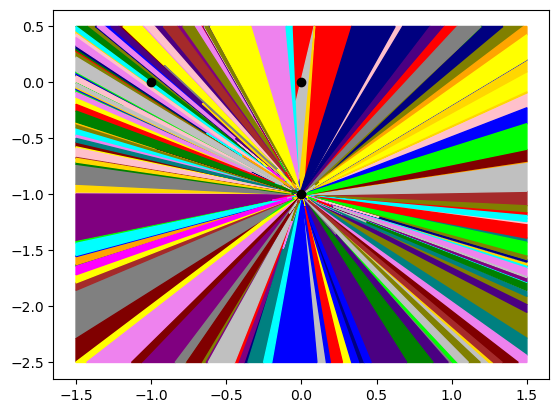

In [37]:
regions = exact_count_2D(
    model._features,
    images_plane,
    init_vertices=[[-1.5, -2.5], [-1.5, 0.5], [1.5, 0.5], [1.5, -2.5]]
)
fig = plot_regions_exact(regions)
print(f"Number of regions: {len(regions)}")
plt.show()

In [38]:
def images_for_experiment(n_runs):
    image_set = []
    for i in range(n_runs):
        images_plane = random_mnist_images(3, MNIST_PATH, image_size=image_size)
        #zero = 10**(-3)*torch.ones((1, image_size**2, 1), dtype=torch.float32)
        #images_plane = torch.cat((images_plane, zero), dim=0)
        image_set.append(images_plane)
    return image_set

def count_for_experiment(layers, init_vertices):
    image_set = images_for_experiment(5)
    counts = np.zeros((len(image_set),))
    for i, images_plane in enumerate(image_set):
        regions = exact_count_2D(layers, images_plane, init_vertices)
        counts[i] = len(regions)
    return np.mean(counts)

In [39]:
def experiment(width=16, depth=4, n_runs=5, with_closeup=True):
    model = MLP(n_in=image_size**2, width=width, depth=depth)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    total_step = len(train_loader)
    init_vertices = [[-500, -500], [-500, 500], [500, 500], [500, -500]]

    x_vals = np.linspace(1, num_epochs, num=num_epochs, dtype=int)
    if with_closeup:
        closeup = np.array([0.02, 0.04, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5])
        x_vals = np.concatenate((np.array([0]), closeup, x_vals))
    else:
        x_vals = np.concatenate((np.array([0]), x_vals))
    region_evol = np.zeros((len(x_vals),))

    counts = count_for_experiment(model._features, init_vertices=init_vertices)
    region_evol[0] = counts
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch==0 and with_closeup:
                if i in np.array(total_step * closeup, dtype=int):
                    idx = np.where(np.array(total_step * closeup, dtype=int) == i)[0][0]
                    print("Counting ...")
                    counts = count_for_experiment(model._features, init_vertices=init_vertices)
                    region_evol[idx+1] = counts

            if (i + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item()}")

        print("Counting ...")
        counts = count_for_experiment(model._features, init_vertices=init_vertices)
        idx = np.where(x_vals == epoch + 1)[0][0]
        region_evol[idx] = counts
    return x_vals, region_evol

In [40]:
n_expe = 5
curves = []
for i in range(n_expe):
    print(f"Experiment {i+1}/{n_expe}")
    x_vals, region_evol = experiment(width=16, depth=4)
    curves.append(region_evol)

Experiment 1/5
Counting ...
Counting ...
Counting ...
Counting ...
Counting ...
Epoch [1/10], Step [100/469], Loss: 1.294070839881897
Counting ...
Counting ...
Epoch [1/10], Step [200/469], Loss: 0.7185338735580444
Counting ...
Epoch [1/10], Step [300/469], Loss: 0.5394895672798157
Epoch [1/10], Step [400/469], Loss: 0.3917352557182312
Counting ...
Epoch [2/10], Step [100/469], Loss: 0.3954019248485565
Epoch [2/10], Step [200/469], Loss: 0.3178415596485138
Epoch [2/10], Step [300/469], Loss: 0.4257842004299164
Epoch [2/10], Step [400/469], Loss: 0.35066038370132446
Counting ...
Epoch [3/10], Step [100/469], Loss: 0.21688592433929443
Epoch [3/10], Step [200/469], Loss: 0.2485453337430954
Epoch [3/10], Step [300/469], Loss: 0.23776662349700928
Epoch [3/10], Step [400/469], Loss: 0.19965842366218567
Counting ...
Epoch [4/10], Step [100/469], Loss: 0.21369098126888275
Epoch [4/10], Step [200/469], Loss: 0.31815803050994873
Epoch [4/10], Step [300/469], Loss: 0.15695162117481232
Epoch [4/10

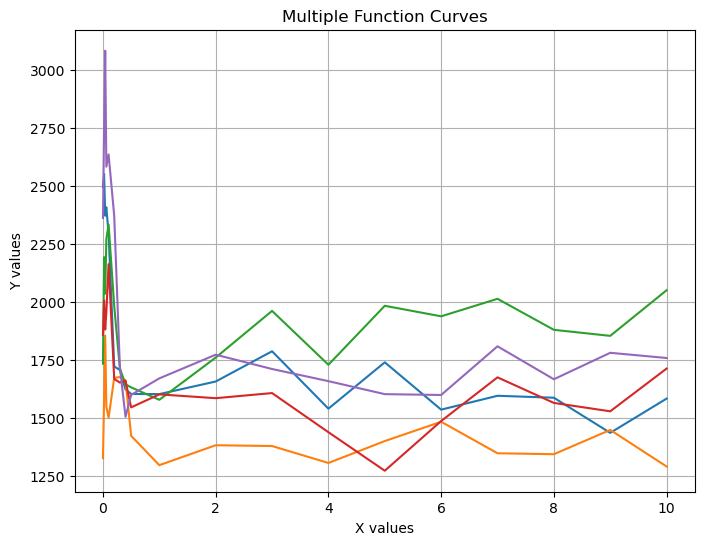

In [41]:
curves_arr = np.array(curves)

plt.figure(figsize=(8, 6))
for i, y in enumerate(curves_arr):
    plt.plot(x_vals, y)

# Add labels, legend, and title
plt.xlabel("X values")
plt.ylabel("Y values")
plt.title("Multiple Function Curves")
plt.grid(True)
plt.show()

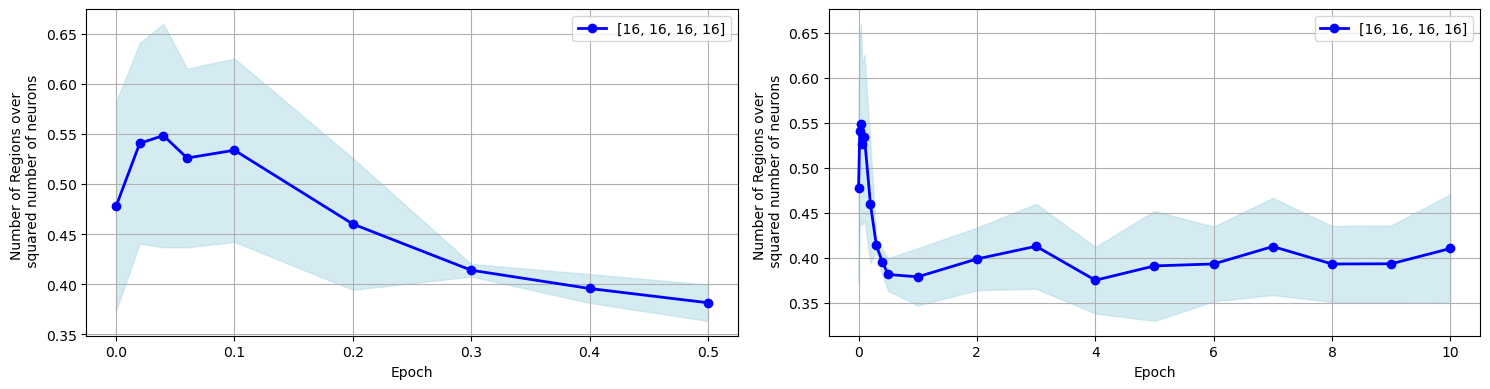

In [42]:
curves_arr = np.array(curves)/((model.n_neurons)**2)
mean_curve = np.mean(curves_arr, axis=0)
min_curve = np.min(curves_arr, axis=0)
max_curve = np.max(curves_arr, axis=0)
std_dev = np.std(curves_arr, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
# Closeup
axes[0].plot(x_vals[:9], mean_curve[:9], label = "[16, 16, 16, 16]", color="blue", linewidth=2, marker='o')
axes[0].fill_between(x_vals[:9], mean_curve[:9] - std_dev[:9], mean_curve[:9] + std_dev[:9], color="lightblue", alpha=0.5)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Number of Regions over \n squared number of neurons")
axes[0].legend()
axes[0].grid(True)

# Full
axes[1].plot(x_vals, mean_curve, label = "[16, 16, 16, 16]", color="blue", linewidth=2, marker='o')
axes[1].fill_between(x_vals, mean_curve - std_dev, mean_curve + std_dev, color="lightblue", alpha=0.5)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Number of Regions over \n squared number of neurons")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()

Number of regions: 2132


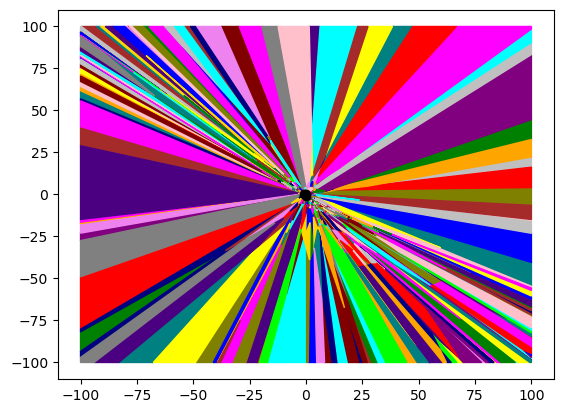

In [44]:
images_plane = random_mnist_images(3, MNIST_PATH, image_size=image_size)

regions = exact_count_2D(
    model._features,
    images_plane,
    init_vertices=[[-100, -100], [-100, 100], [100, 100], [100, -100]]
)
fig = plot_regions_exact(regions)
print(f"Number of regions: {len(regions)}")
plt.show()